In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go


In [2]:
predictions_gpt_df = pd.read_csv('MovieSummaries/movies_gpt2_prediction.csv')
predictions_gpt_df = predictions_gpt_df.rename(columns={'feminism':"prediction_gpt"})
predictions_SVM_df = pd.read_csv('MovieSummaries/movies_svm_predictions.csv')
predictions_SVM_df = predictions_SVM_df.rename(columns={'Feminism prediction':"prediction_svm"})
columns_to_keep = ['Wikipedia movie ID', 'prediction_svm']
predictions_SVM_df = predictions_SVM_df[columns_to_keep]


In [3]:
predictions_df = pd.merge(predictions_gpt_df, predictions_SVM_df, left_on='Wikipedia movie ID',right_on='Wikipedia movie ID', how='outer')
predictions_df.loc[predictions_df['prediction_svm'].isna(), 'prediction_svm'] = 1

In [4]:
predictions_df['is_equal'] = predictions_df['prediction_svm'] == predictions_df['prediction_gpt']

In [5]:
test = predictions_df[predictions_df['is_equal']==False]
test.shape

(15057, 18)

In [6]:
def extract_year(date_str):
        if pd.isna(date_str):  # Check if the value is NaN
            return None  # Return None or a suitable placeholder for NaN
        if len(date_str) == 4:  # Check if it's a four-digit year
            return int(date_str)  # Return the year as an integer
        return pd.to_datetime(date_str, errors='coerce').year  # Convert to datetime and extract year


    # Extract the year without modifying the original column
predictions_df['Year'] = predictions_df['Movie release date'].apply(extract_year)

In [7]:
predictions_df.to_csv('predictions_df.csv', index=False)

In [8]:
predictions_df.columns

Index(['Unnamed: 0', 'Wikipedia movie ID', 'Summaries', 'Freebase movie ID',
       'Movie name', 'Movie release date', 'Movie box office revenue',
       'Movie runtime', 'Movie languages (Freebase ID:name tuples)',
       'Movie countries (Freebase ID:name tuples)',
       'Movie genres (Freebase ID:name tuples)', 'Year',
       'Country dictionnaire', 'Genre dictionnaire', 'Language dictionnaire',
       'prediction_gpt', 'prediction_svm', 'is_equal'],
      dtype='object')

# Nombre de films qui réussissent le test par an

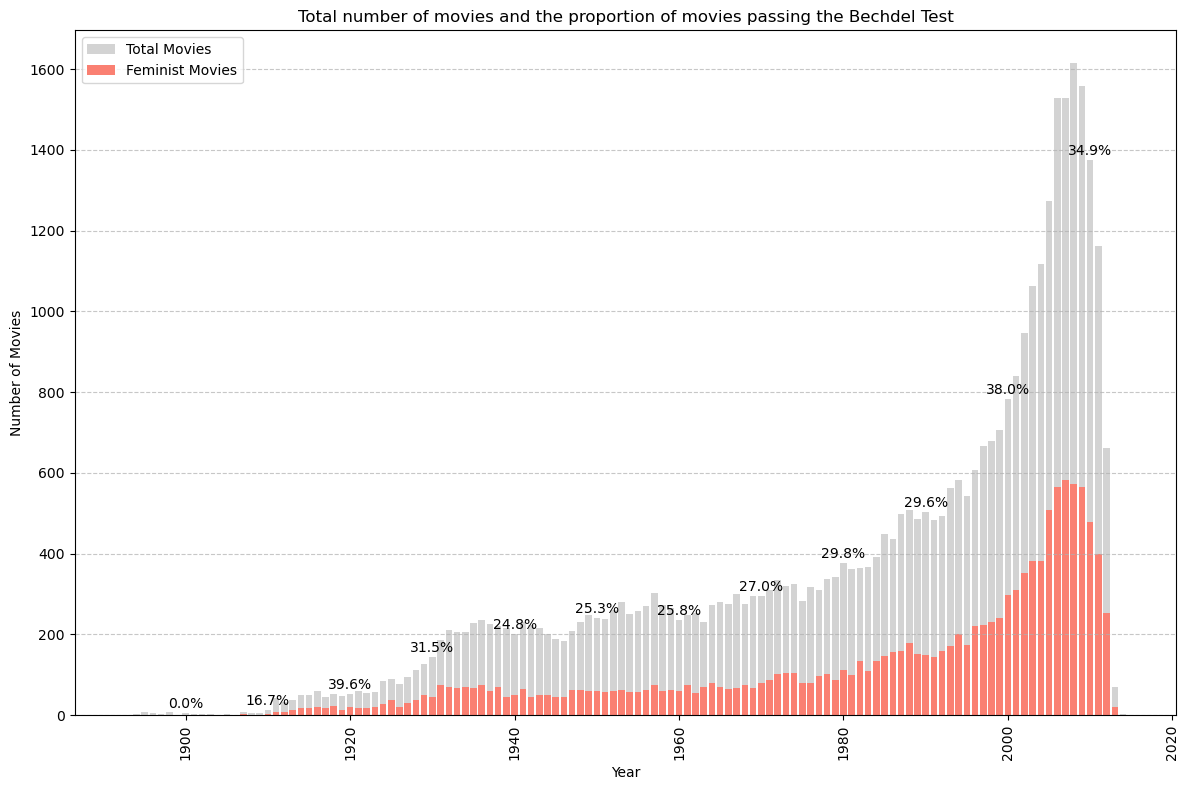

In [9]:
# Count the total number of movies per year
count_per_year_all = predictions_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count_gpt = predictions_df[predictions_df['prediction_gpt'] == True]
count_per_year_gpt = feminist_count_gpt.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_gpt, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Total number of movies and the proportion of movies passing the Bechdel Test')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        plt.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


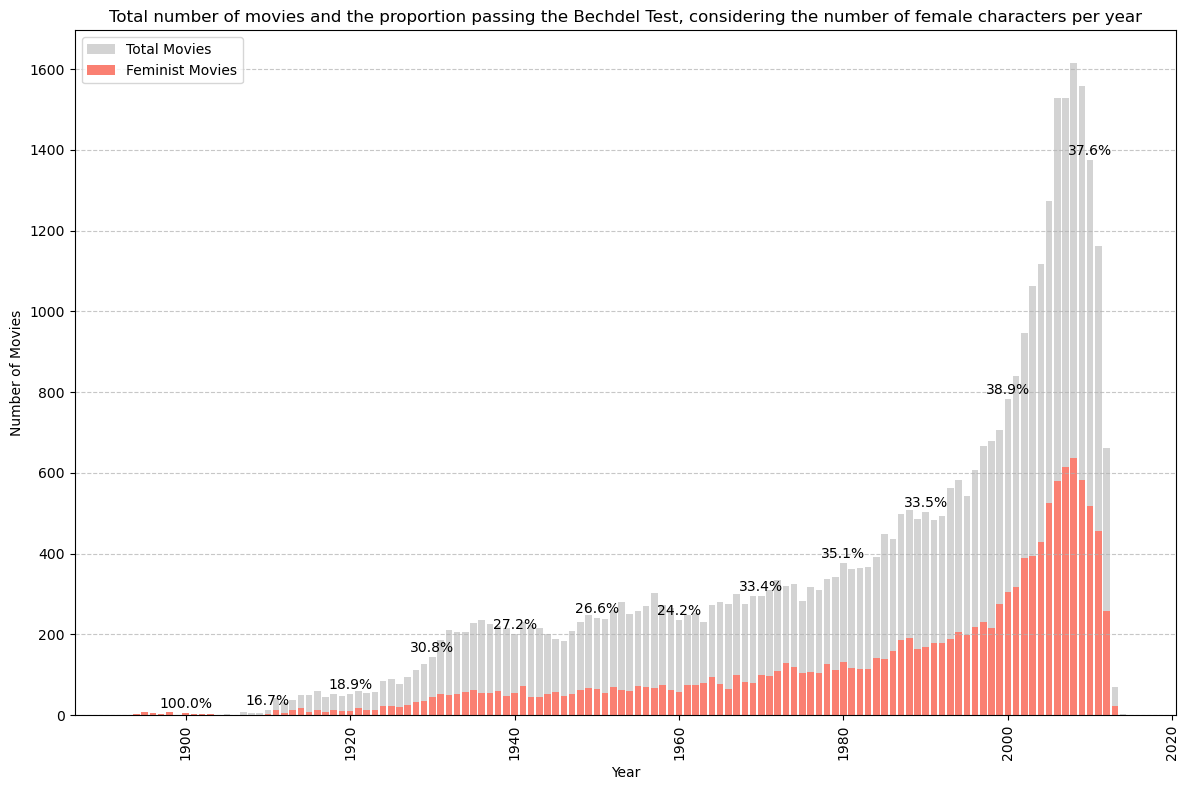

In [10]:
# Count the number of feminist movies per year
feminist_count_svm = predictions_df[predictions_df['prediction_svm'] == True]
count_per_year_svm = feminist_count_svm.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_svm, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Total number of movies and the proportion passing the Bechdel Test, considering the number of female characters per year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        plt.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


# Pourcentage de films qui réussissent le test de Beschdel selon le pays

In [27]:
predictions_df['Country dictionnaire'] = predictions_df['Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_df['Genre dictionnaire'] = predictions_df['Movie genres (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_explode_country = predictions_df.explode('Country dictionnaire')

predictions_explode_country['passes_bechdel_svm'] = predictions_explode_country['prediction_svm']
predictions_explode_country['passes_bechdel_gpt'] = predictions_explode_country['prediction_gpt']


grouped_svm = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_svm', 'sum')  # Somme des valeurs True
).reset_index()

grouped_gpt = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_gpt', 'sum')  # Somme des valeurs True
).reset_index()

In [28]:
films_per_country = predictions_explode_country.groupby('Country dictionnaire').size().reset_index(name='total_movies')
top_5_countries = films_per_country.sort_values(by='total_movies', ascending=False).head(5)
top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']

print(top_5_countries)

    Country dictionnaire  total_movies
118            /m/09c7w0         20788
53              /m/03rk0          4751
106             /m/07ssc          4036
130            /m/0f8l9c          2296
127            /m/0d060g          1491


In [29]:
grouped_svm['feminist_percentage'] = grouped_svm['feminist_movies'] / grouped_svm['total_movies'] * 100
grouped_gpt['feminist_percentage'] = grouped_gpt['feminist_movies'] / grouped_gpt['total_movies'] * 100


In [32]:
grouped_gpt = grouped_gpt[(grouped_gpt['Year'] >= 1960) & (grouped_gpt['Year'] < 2008)]
grouped_svm = grouped_svm[(grouped_svm['Year'] >= 1960) & (grouped_svm['Year'] < 2008)]

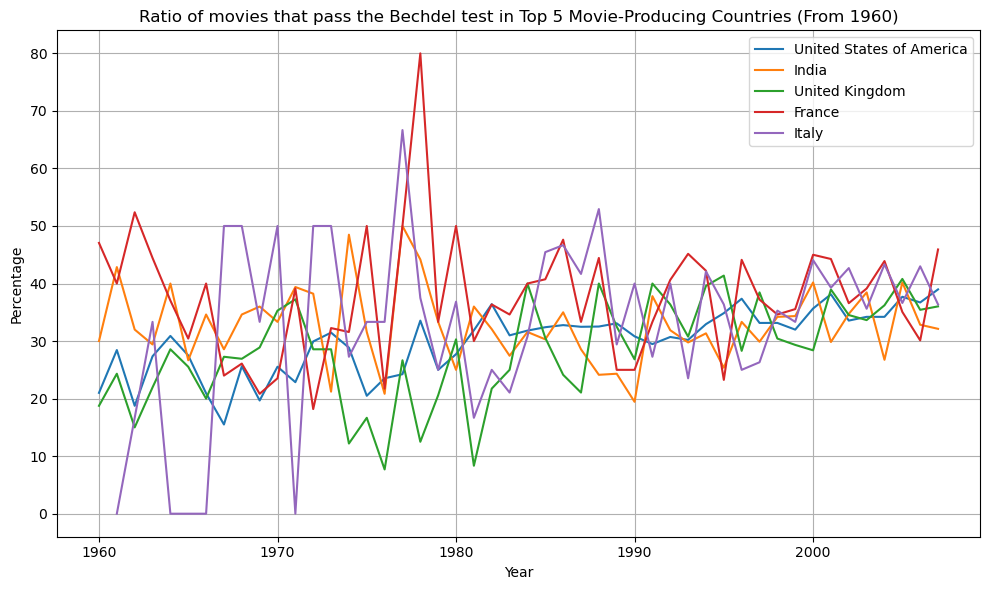

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_gpt[grouped_gpt['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

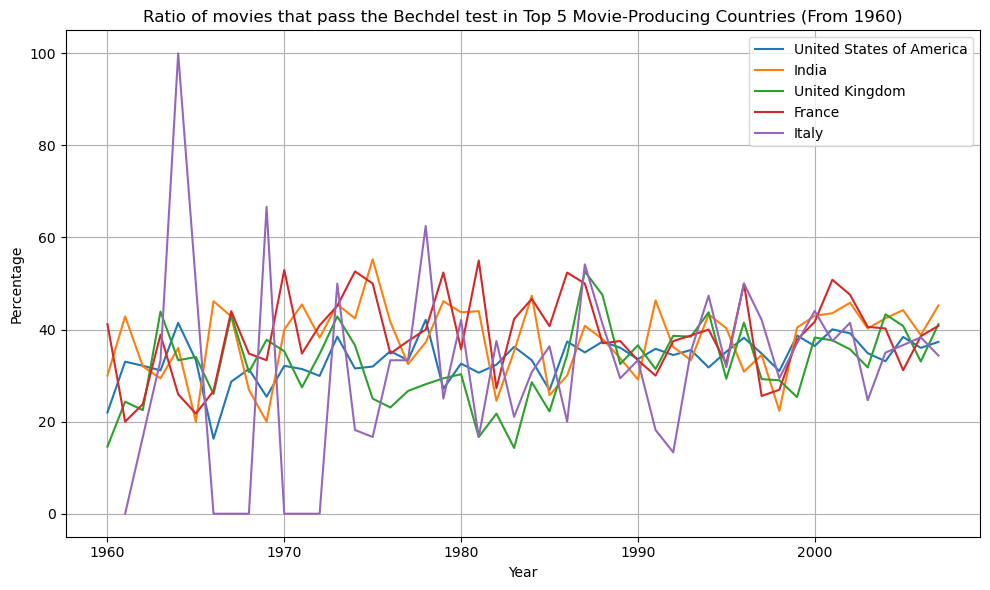

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_svm[grouped_svm['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Pourcentage de films qui réussissent le test selon le genre

# Pourcentage de films oscarisés qui vérifient le test de Bechdel 

In [130]:
oscars_df = pd.read_csv('MovieSummaries/oscars_df.csv')
columns_to_keep = ['Film', 'Award', 'IMDB Rating']
oscars_df = oscars_df[columns_to_keep]

In [131]:
# Films oscarisés et nominés 
oscars_percentage = pd.merge(predictions_df, oscars_df, left_on = 'Movie name', right_on = 'Film', how='inner')

In [132]:
columns_to_keep = ['Movie name','prediction_gpt', 'prediction_svm', 'Award']
oscars_percentage = oscars_percentage[columns_to_keep]

In [134]:
from dash import Dash, dcc, html, Input, Output
import matplotlib.pyplot as plt
import pandas as pd
import io
import base64

oscars_percentages

# Fonction pour calculer les proportions
def calculate_percentage(df, model_col, award_type):
    if award_type == "Nominee":
        # Inclure les gagnants dans les nominés
        relevant_df = df[df['Award'].isin(['Winner', 'Nominee'])]
    else:
        # Filtrer uniquement les gagnants
        relevant_df = df[df['Award'] == award_type]

    total = len(relevant_df)
    passing = len(relevant_df[relevant_df[model_col] == 1])
    failing = total - passing

    return passing, failing

# Fonction pour générer un graphique et le convertir en image
def generate_pie_chart(df, model_col):
    data_winner = calculate_percentage(df, model_col, "Winner")
    data_nominee = calculate_percentage(df, model_col, "Nominee")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Camembert pour les gagnants
    axes[0].pie(
        data_winner,
        labels=['Pass', 'Fail'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightgreen', '#ff9999']
    )
    axes[0].set_title("Winners")

    # Camembert pour les nominés
    axes[1].pie(
        data_nominee,
        labels=['Pass', 'Fail'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightgreen', '#ff9999']
    )
    axes[1].set_title("Nominees")

    plt.tight_layout()

    # Sauvegarder en mémoire tampon
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close(fig)

    # Convertir en base64
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Initialisation de l'application Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Bechdel Test Pie Charts", style={'textAlign': 'center'}),

    # Container pour les graphiques
    html.Div(id="pie-chart-container"),

    # Dropdown pour sélectionner le modèle
    html.Div([
        html.Label("Select Bechdel Test Model:"),
        dcc.Dropdown(
            id="model-dropdown",
            options=[
                {"label": "GPT Prediction", "value": "prediction_gpt"},
                {"label": "SVM Prediction", "value": "prediction_svm"},
            ],
            value="prediction_gpt", 
            clearable=False
        ),
    ], style={"width": "50%", "margin": "auto", "margin-top": "20px"}),  # Ajout d'un espacement avec margin-top
])

@app.callback(
    Output("pie-chart-container", "children"),
    [Input("model-dropdown", "value")]
)
def update_charts(selected_model):
    img_base64 = generate_pie_chart(oscars_percentage, selected_model)
    return html.Img(src=f"data:image/png;base64,{img_base64}", style={"width": "100%"})

# Lancer l'application
if __name__ == "__main__":
    app.run_server(debug=True, port='8051')